# Train Triplet Model Using Table API

## Table of Contents
* [Overview](#Overview)
* [Set the Environment](#Set-the-environment)
* [Prepare the Data](#Prepare-the-data)
* [Build a Triplet Model](#Build-a-triplet-model)
* [Train the Model](#Train-the-model)
* [Assess the Model](#Assess-the-model)

## Overview <a id="Overview"></a>
This example shows how to train a Triplet Network by invoking the ImageEmbeddingTable API to create train/test data sets. We then show how to train and assess the Triplet Network.

The data used for this example consists of a subset of images obtained from [Google's Open Image V4](https://arxiv.org/abs/1811.00982). To recreate this data set:

Our data is stored in a path accessible by the CAS server. The data is structured in a directory as follows:

../data <br/>
  |--german_shepherd <br/>
  |  |--image1 <br/>
  |  |--image2 <br/>
  |  |--etc.. <br/>
  |--golden_retriever <br/>
  |  |--image1 <br/>
  |  |--image2 <br/>
  |  |--etc.. <br/>
  |--labrador_retriever <br/>
  |  |--image1 <br/>
  |  |--image2 <br/>
  |  |--etc.. <br/>
  |--etc.. <br/>
  
Note: Image data can only be loaded from the server. Client-side loads of image data are unsupported.

## Set the Environment <a id="Set-the-environment"></a>

First, set notebook environment by doing the following:
1. Import relevant modules
2. Use matplotlib inline magic so plots render correctly
3. Start a CAS session

<span style="color: red"> **Remember:** </span> Change **`host_name`** and **`port_number`** to match your CAS server. You should also have an authinfo (authentication) file set up as well.

In [1]:
from swat import *
from pprint import pprint

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)


In [3]:
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.lr_scheduler import *
from dlpy.images import *
from dlpy.image_embedding import *
from dlpy.embedding_model import EmbeddingModel

In [4]:
s = CAS('cloud.example.com', port_number)
s.sessionprop.setsessopt(caslib='CASUSER', timeout=31535000)

NOTE: 'CASUSER(userid)' is now the active caslib.


+ Elapsed: 0.00021s, sys: 0.000197s, mem: 0.256mb

# Prepare the Data <a id="Prepare-the-data"></a>
Now, we will create an ImageEmbeddingTable for a Triplet Network. Essentially, this is an ImageTable that is composed of a trio of images and some data about each image. The images consist of an anchor image, a positive image (one of the same class), and a negative image (one of a different class).

For arguments to the **`ImageEmbeddingTable.load_files`** method, we specify the current CAS session, the server-side path where images reside, the model type as a Triplet Network, and label level. Since the path to any of our images is of the form ../data/category/image_name, we want to choose **`label_level_ =-2`** so that 'category' is used for that image's label.  

<span style="color: red">**Remember:**</span> Change _server_side_data_path_ to the path where your images reside.

In [5]:
my_table= ImageEmbeddingTable.load_files(s, path='server_side_data_path', 
                                         embedding_model_type='triplet', label_level=-2)

In [6]:
my_table.label_freq[3]

,Level,Frequency
"german_shepherd,german_shepherd,golden_retriever",1,15
"german_shepherd,german_shepherd,labrador_retriever",2,16
"german_shepherd,german_shepherd,miniature_poodle",3,15
"german_shepherd,german_shepherd,soft-coated_wheaten_terrier",4,13
"german_shepherd,german_shepherd,toy_poodle",5,20
"golden_retriever,golden_retriever,german_shepherd",6,15
"golden_retriever,golden_retriever,labrador_retriever",7,14
"golden_retriever,golden_retriever,miniature_poodle",8,18
"golden_retriever,golden_retriever,soft-coated_wheaten_terrier",9,9
"golden_retriever,golden_retriever,toy_poodle",10,17


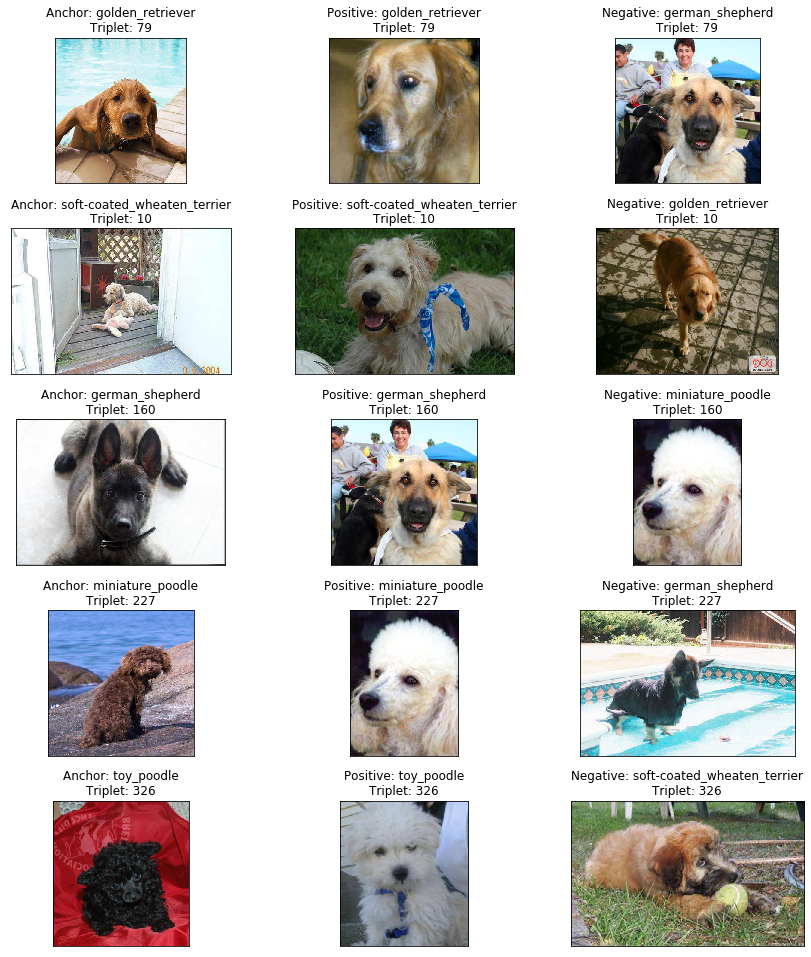

In [7]:
my_table.show()

In [8]:
my_table.numrows()

[numrows]

 512

+ Elapsed: 0.000504s, user: 0.000465s, mem: 0.399mb

## Build a Triplet Model <a id="Build-a-triplet-model"></a>
A Triplet Network uses three copies of a neural network to learn discriminative features. We use ResNet18 as a base network for these three copies. Likewise, ResNet18 will serve as the base of our embedding, but in order to customize the embedding output, we add an embedding layer to ResNet18 that is also copied. 

We define our embedding layer to be a dense 4-neuron layer with an identity activation function. If this is not given, the last layer before the output layer will be used as the embedding layer.

The output features from each network are fed into an embedding loss layer to compute the triplet loss function. The triplet loss function is designed to minimize the Euclidean distance between the anchor image and the positive image and increase the distance between the anchor image and the negative image. Margin is used to tune how discriminative the features should be.

The resulting Triplet Network structure is stored in memory as the table "test_tr".

In [9]:
resnet18_model = ResNet18_Caffe(s,
                                width=224,
                                height=224,
                                random_crop='RESIZETHENCROP',
                                random_mutation='random'
                                )

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


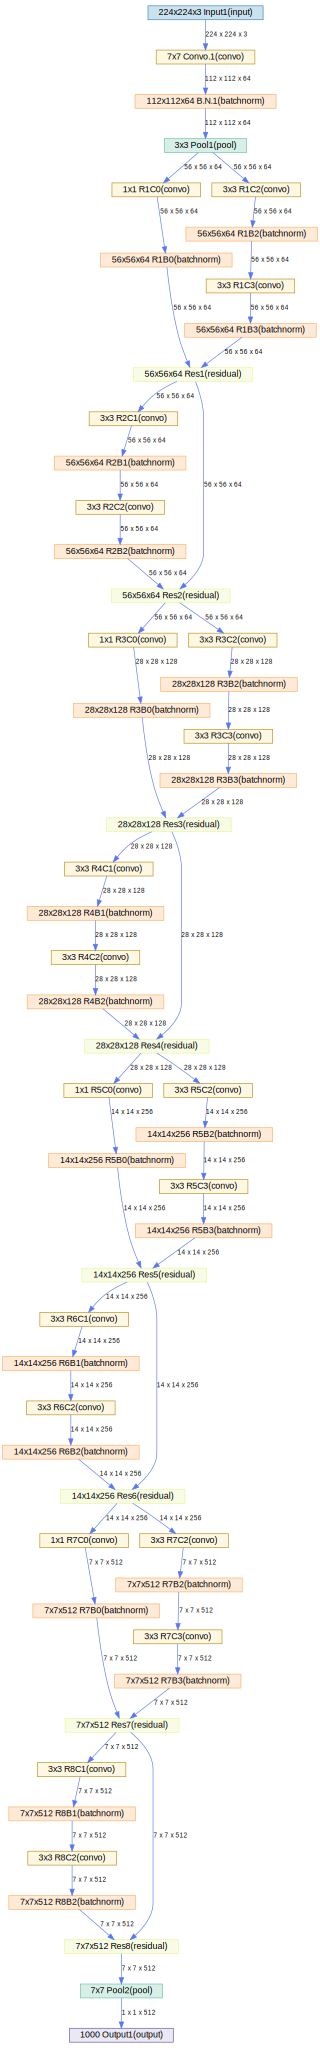

In [10]:
resnet18_model.plot_network()

In [11]:
embedding_layer = Dense(n=4, act='identity')

In [12]:
model_tr = EmbeddingModel.build_embedding_model(resnet18_model, model_table='test_tr',
                                              embedding_model_type='triplet', margin=-3.0,
                                              embedding_layer=embedding_layer)

NOTE: Convert the branch model into a functional model.
NOTE: Remove the task layers from the model.
NOTE: Model compiled successfully.


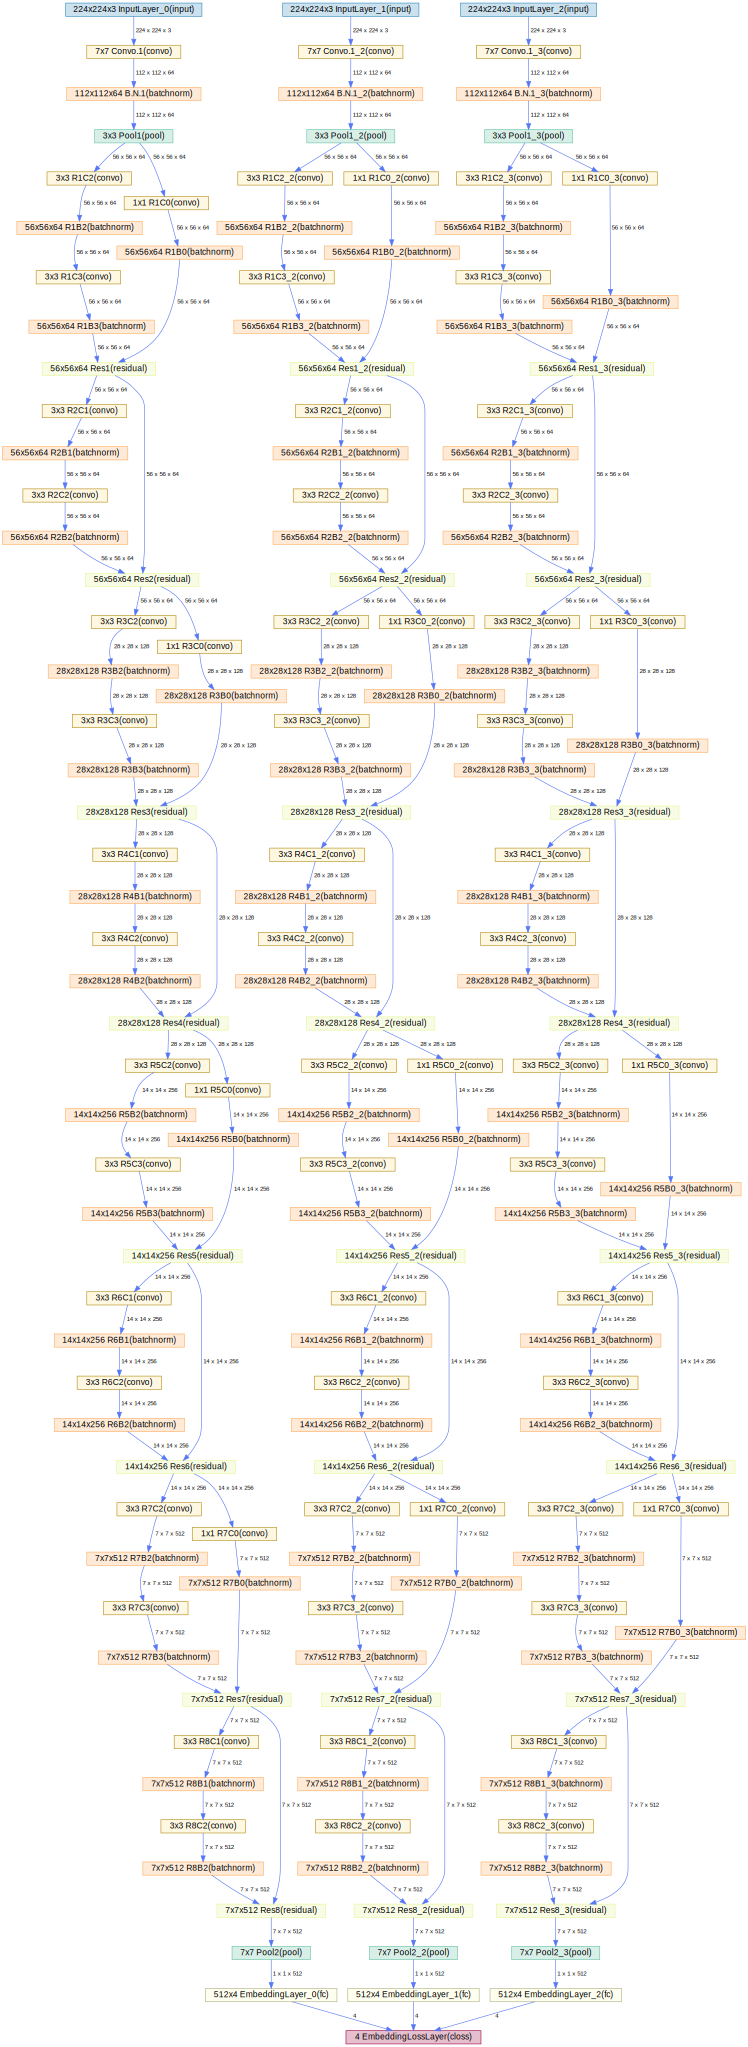

In [13]:
model_tr.plot_network()

Note that, not only do we have three copies of ResNet18, but we have the 4-neuron EmbeddingLayer and an EmbeddingLossLayer to aggregate and compare the output.

# Train the model <a id="Train-the-model"></a>
First, we import utilities needed in order to train the model on GPU. Then, we set some of the optimization parameters.

We train the model using **`fit_embedding_model()`**, which automatically binds the input and output information from the image embedding table to the model. 

In [14]:
from dlpy.model import Gpu
gpu = Gpu(devices=1)

In [15]:
from dlpy.model import Optimizer, MomentumSolver, AdamSolver
solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.0001, step_size=20), clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=8, log_level=2, max_epochs=40, reg_l2=0.0001)

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [16]:
model_tr.fit_embedding_model(data=my_table, optimizer=optimizer, n_threads=4, gpu=gpu, seed=1234,record_seed=23435)

NOTE: Training from scratch.
NOTE: Using cloud.example.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 33548364.
NOTE:  The approximate memory cost is 885.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       4.23 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 8.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0        0.0001          0.2692      2.247     8.54
NOTE:  1        0.0001         0.04495      2.475     3.71
NOTE:  2        0.0001        -0.03341      2.747     3.70
NOTE:  3        0.0001         -0.1182      3.064     3.72
NOTE:  4        0.0001         -0.1294      2.832     3.93
NOTE:  5        0.0001         -0.1503      3.537     3.59
NOTE:  6        0.0001         -0.1322      3.223    

,Descr,Value
0,Model Name,test_tr
1,Model Type,Convolutional Neural Network
2,Number of Layers,163
3,Number of Input Layers,3
4,Number of Output Layers,0
5,Number of Convolutional Layers,63
6,Number of Pooling Layers,6
7,Number of Fully Connected Layers,3
8,Number of Batch Normalization Layers,63
9,Number of Residual Layers,24


# Assess the model <a id="Assess-the-model"></a>
Having trained the Triplet Network, we need to test it. Like the training data, the test data needs three images and their corresponding image data. Again, we use the ImageEmbeddingTable API to create data in this format. We form 64 image triplets from images in the given path.

Note, however, that the Triplet Network is three copies of a network, joined at an embedding loss layer. Because it has three networks, we have to reconsider what scoring the model means. In the case of the Triplet Network, scoring an observation produces computed variables: \_DL_Pred0\_ and \_DL_Pred1\_. \_DL_Pred0\_ denotes the Euclidean distance between the anchor image and the positive image. For a well-trained embedding, this distance should be small. \_DL_Pred1\_ denotes the distance between the anchor image and the negative image. This distance should be large.

We consider an observation "correctly classified" if \_DL_Pred0\_ > \_DL_Pred1\_. The means of these distances can provide an idea of the interclass and intraclass distance of the embedding.

<span style="color: red">**Remember:**</span> Change _server_side_data_path_ to the path where your images reside.

In [17]:
my_table_test= ImageEmbeddingTable.load_files(s, path='server_side_data_path', 
                                              embedding_model_type='triplet', label_level=-2, 
                                              n_samples=64)

In [18]:
from dlpy.model import Gpu
gpu = Gpu(devices=1)
model_tr.predict(data=my_table_test, gpu=gpu, random_crop='RESIZETHENCROP')

NOTE: Due to data distribution, miniBatchSize has been limited to 2.
NOTE: Using cloud.example.com: 1 out of 2 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            64
 1  Number of Observations Used            64
 2          Mean Absolute Error      5.903636
 3                   Loss Error      -1.11006

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(userid)  Valid_Res_6qZkpb    64       21   
 
                                                  casTable  
 0  CASTable('Valid_Res_6qZkpb', caslib='CASUSER(userid)')  

+ Elapsed: 8.07s, user: 5.34s, sys: 2.49s, mem: 1.17e+03mb

In [19]:
s.summary(table=model_tr.valid_res_tbl, inputs=['_DL_Pred0_', '_DL_Pred1_'])

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,_DL_Pred0_,0.462180,6.138938,64.0,0.0,2.446042,156.546660,1.062526,0.132816,1.128961,454.044211,71.124572,43.438591,18.416804,4.746103e-27,0.774687,1.234301
1,_DL_Pred1_,1.336677,6.048071,64.0,0.0,3.457595,221.286054,1.230568,0.153821,1.514298,860.518224,95.400759,35.590293,22.478039,8.633233e-32,0.307991,-0.732296


Here, we calculate the number of correct rows where "correct" means the anchor is closer to the positive image than the negative image. We also calculate the total number of rows and use the two statistics to determine the proportion of correctly embedded observations.

In [20]:
tot_obs = s.numrows(table=dict(name=model_tr.valid_res_tbl.name))
correctly_ranked_obs = s.numrows(table=dict(name=model_tr.valid_res_tbl.name, where='_DL_Pred0_ < _DL_Pred1_'))

In [21]:
correctly_ranked_obs['numrows']/tot_obs['numrows']

0.765625

## Conclusion
Though there's room for improvement, our model does classify most dogs correctly. 

In [ ]:
s.endsession()